# Test Caputo Integration

## Import Statements

In [1]:
from caputo import caputo_euler, naive_caputo_euler, caputo_l1_diff
from matplotlib import pyplot as plt
import numpy as np
from scipy.special import gamma
import time
import torch

## Constant Case

Similar to an integer derivative, the Caputo derivative of a constant is zero.

$
\begin{align*}
_{t_{0}}^{\mathrm{C}}\mathrm{D}_{x}^{\alpha}[c] &= 0
\end{align*}
$

In [2]:
# Test constant
alpha = 0.5
t0 = 0
tf = 1
num_step = 1000
y0 = 1

f = lambda t, y: 0

start = time.time()
ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)
stop = time.time()
print(f'Vectorized: {stop - start} sec')

start = time.time()
ts2, ys2 = naive_caputo_euler(f, alpha, (t0, tf), num_step, y0)
stop = time.time()
print(f'Naive: {stop - start} sec')

Vectorized: 0.0028839111328125 sec
Naive: 0.3065359592437744 sec


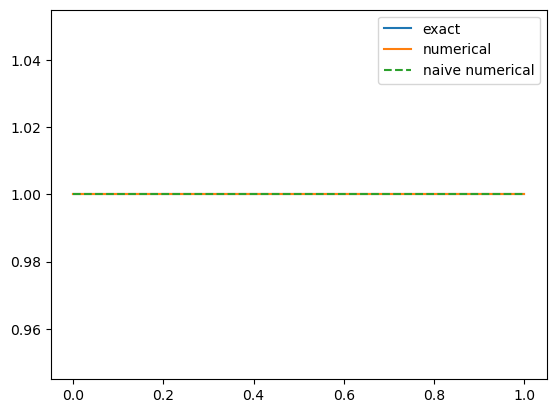

In [3]:
fig, ax = plt.subplots()
ax.plot(ts, y0 * np.ones(ts.size), label='exact')
ax.plot(ts, ys, label='numerical')
ax.plot(ts2, ys2, label='naive numerical', ls='--')
ax.legend()

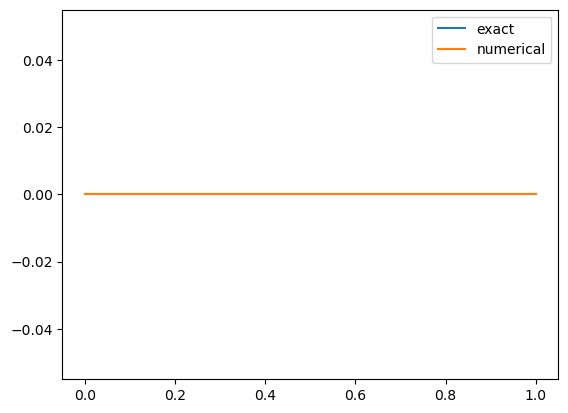

In [4]:
# Now derivative
fps = caputo_l1_diff(ys, alpha, dt=((tf - t0) / num_step))
fig, ax = plt.subplots()
ax.plot(ts, np.vectorize(f)(ts, ys), label='exact')
ax.plot(ts, fps, label='numerical')
ax.legend()

## Polynomial Case

For $\lceil \alpha \rceil - 1 < b$,

$
\begin{align*}
_{t_{0}}^{\mathrm{C}}\mathrm{D}_{x}^{\alpha}[x^{b}] &=
\frac{\Gamma(b + 1)}{\Gamma(b - \alpha + 1)} (x^{b - \alpha} - t_{0}^{b - \alpha})
\end{align*}
$

Error convergence is done which confirms that the Caputo-Euler scheme is $\alpha$-order accurate.

In [5]:
# Test power of a function
alpha = 0.6
b = 3
t0 = 0
tf = 1
num_step = 1000
y0 = 0

f = lambda t, y, alpha=alpha, b=b: gamma(b + 1) / gamma(b - alpha + 1) * (t ** (b - alpha) - t0 ** (b - alpha))

start = time.time()
ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)
stop = time.time()
print(f'Vectorized: {stop - start} sec')

start = time.time()
ts2, ys2 = naive_caputo_euler(f, alpha, (t0, tf), num_step, y0)
stop = time.time()
print(f'Naive: {stop - start} sec')

Vectorized: 0.007590293884277344 sec
Naive: 0.8751668930053711 sec


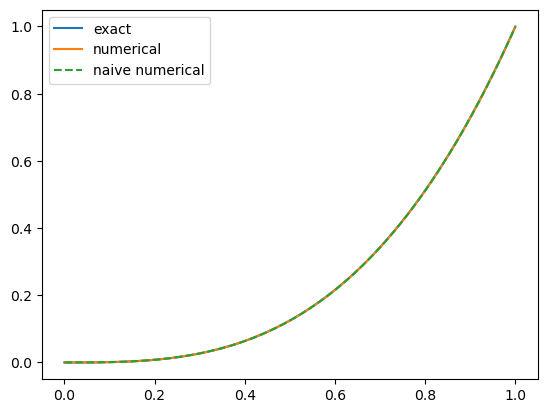

In [6]:
fig, ax = plt.subplots()
ax.plot(ts, ts ** b, label='exact')
ax.plot(ts, ys, label='numerical')
ax.plot(ts2, ys2, label='naive numerical', ls='--')
ax.legend()

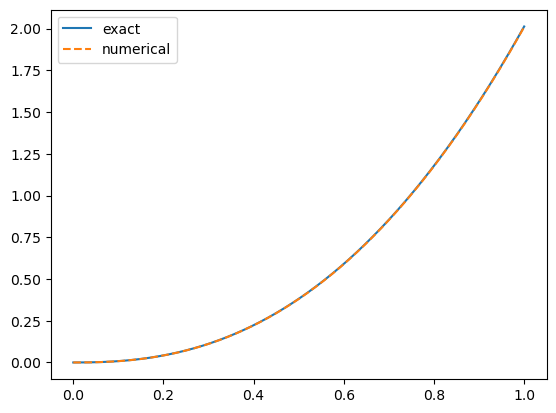

In [7]:
# Now derivative
fps = caputo_l1_diff(ys, alpha, dt=0.001)
fig, ax = plt.subplots()
ax.plot(ts, np.vectorize(f)(ts, ys), label='exact')
ax.plot(ts, fps, label='numerical', ls='--')
ax.legend()

In [8]:
# Error convergence study
alpha = 0.5
b = 3
t0 = 0
tf = 1
num_steps = [500, 1000, 2000, 4000, 8000]
errs = []
y0 = 0

f = lambda t, y, alpha=alpha, b=b: gamma(b + 1) / gamma(b - alpha + 1) * (t ** (b - alpha) - t0 ** (b - alpha))

for num_step in num_steps:
    ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)
    errs.append(abs(ys[-1] - 1))

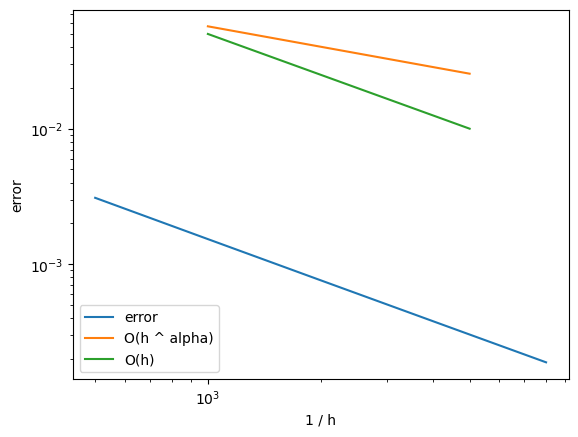

In [9]:
fig, ax = plt.subplots()
ns = np.linspace(1000, 5000, 11)
ax.loglog(num_steps, errs, label='error')
ax.loglog(ns, [1.8 / n ** alpha for n in ns], label='O(h ^ alpha)')
ax.loglog(ns, [50 / n for n in ns], label='O(h)')
ax.set_xlabel('1 / h')
ax.set_ylabel('error')
ax.legend()

## SEIRD Model Case

In [10]:
# Try SEIRD model
alpha = 0.95
beta = 0.25
sigma = 0.13
gam = 0.052
mu = 0.005
t0 = 0
tf = 1000
num_step = 200
y0 = np.array([0.99, 0.01, 0, 0, 0])

f = lambda t, y: np.array([
    - beta * (y[0] * y[2]) / (1 - y[4]),
    beta * (y[0] * y[2]) / (1 - y[4]) - sigma * y[1],
    sigma * y[1] - (gam + mu) * y[2],
    gam * y[2],
    mu * y[2]
])

ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)

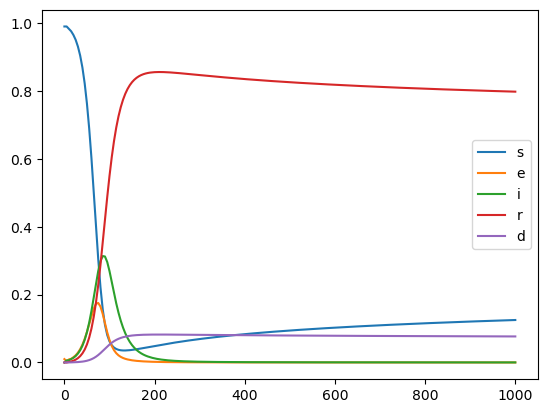

In [11]:
fig, ax = plt.subplots()
ax.plot(ts, ys[:, 0], label='s')
ax.plot(ts, ys[:, 1], label='e')
ax.plot(ts, ys[:, 2], label='i')
ax.plot(ts, ys[:, 3], label='r')
ax.plot(ts, ys[:, 4], label='d')
ax.legend()

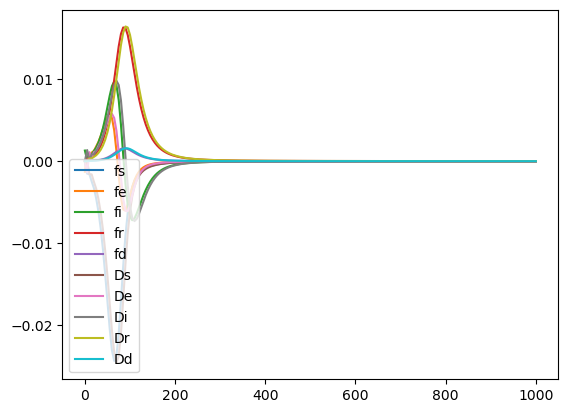

In [12]:
# Check derivatives
fv = np.vectorize(f, signature='(),(5)->(5)')
fs = fv(ts, ys)

fs_num = caputo_l1_diff(ys, alpha, dt=(tf - t0) / num_step)

fig, ax = plt.subplots()
ax.plot(ts, fs[:, 0], label='fs')
ax.plot(ts, fs[:, 1], label='fe')
ax.plot(ts, fs[:, 2], label='fi')
ax.plot(ts, fs[:, 3], label='fr')
ax.plot(ts, fs[:, 4], label='fd')
ax.plot(ts, fs_num[:, 0], label='Ds')
ax.plot(ts, fs_num[:, 1], label='De')
ax.plot(ts, fs_num[:, 2], label='Di')
ax.plot(ts, fs_num[:, 3], label='Dr')
ax.plot(ts, fs_num[:, 4], label='Dd')
ax.legend()

In [13]:
# Error convergence study
alpha = 0.9
beta = 0.25
sigma = 0.13
gam = 0.052
mu = 0.005
t0 = 0
tf = 500
num_steps = [100, 200, 400, 800, 1600]
errs = []
y0 = np.array([0.99, 0.01, 0, 0, 0])

tss = []
yss = []

f = lambda t, y: np.array([
    - beta * (y[0] * y[2]) / (1 - y[4]),
    beta * (y[0] * y[2]) / (1 - y[4]) - sigma * y[1],
    sigma * y[1] - (gam + mu) * y[2],
    gam * y[2],
    mu * y[2]
])

# Ground truth
ts_coarse = np.linspace(t0, tf, 101)
ts_true, ys_true = caputo_euler(f, alpha, (t0, tf), 3200, y0)
tss.append(ts_true)
yss.append(ys_true)
interp_func = lambda fp_slice: np.interp(ts_coarse, ts_true, fp_slice)
ys_true = np.apply_along_axis(interp_func, 0, ys_true)

i = 0
for num_step in num_steps:
    ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)
    tss.append(ts)
    yss.append(ys)
    interp_func = lambda fp_slice: np.interp(ts_coarse, ts, fp_slice)
    ys = np.apply_along_axis(interp_func, 0, ys)
    errs.append(sum([np.trapezoid((ys[:, i] - ys_true[:, i]) ** 2, x=ts_coarse) for i in range(5)]) ** 0.5)
    i += 1

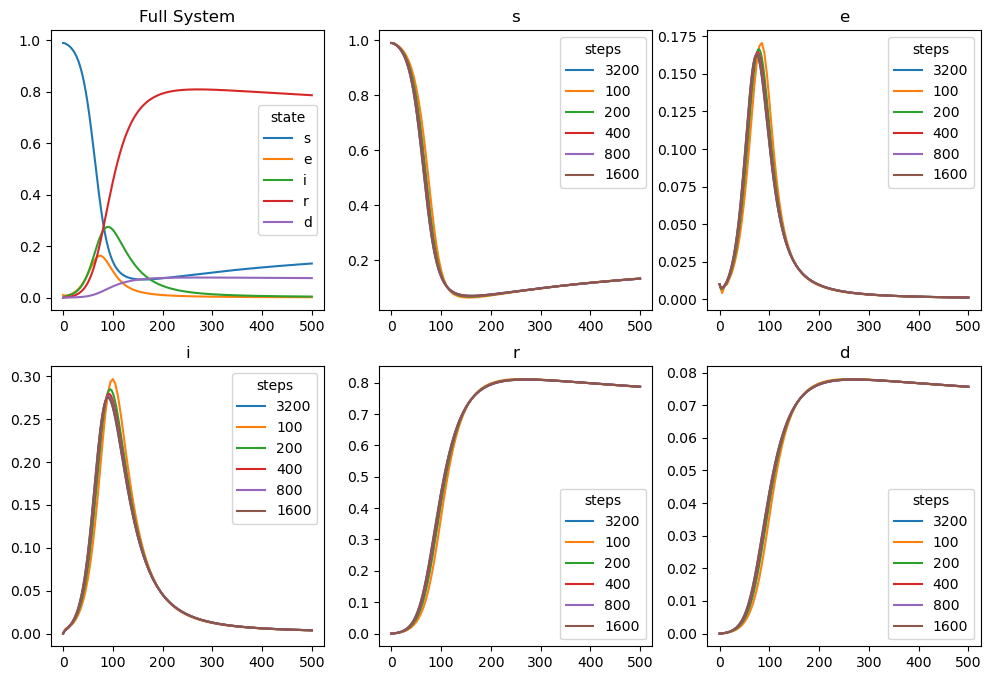

In [14]:
# Plot solutions
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
labels2 = ['3200', '100', '200', '400', '800', '1600']

# High-accuracy solution
for i in range(5):
    ax[0, 0].plot(tss[0], yss[0][:, i], label=labels[i + 1])

for j in range(len(tss)):
    for i in range(5):
        ax[(i + 1) // 3, (i + 1) % 3].plot(tss[j], yss[j][:, i], label=labels2[j])

for i in range(6):
    ax[i // 3, i % 3].set_title(labels[i])
    ax[i // 3, i % 3].legend(title=('state' if i == 0 else 'steps'))

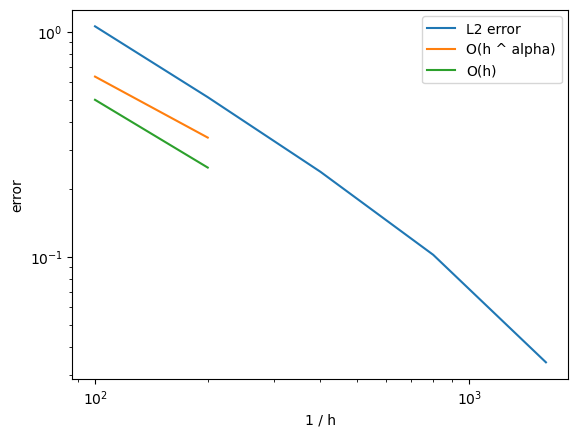

In [15]:
fig, ax = plt.subplots()
ns = np.linspace(100, 200, 11)
ax.loglog(num_steps, errs, label='L2 error')
ax.loglog(ns, [40 / n ** alpha for n in ns], label='O(h ^ alpha)')
ax.loglog(ns, [50 / n for n in ns], label='O(h)')
ax.set_xlabel('1 / h')
ax.set_ylabel('error')
ax.legend()

## Toeplitz Matrix Generation

In [16]:
# Credit Google Gemini
def toeplitz(c, r):
    """
    Creates a Toeplitz matrix from a given first column (c) and first row (r).

    Args:
        c (torch.Tensor): A 1D tensor representing the first column of the Toeplitz matrix.
        r (torch.Tensor): A 1D tensor representing the first row of the Toeplitz matrix.
                          The first element of r should be equal to the first element of c.

    Returns:
        torch.Tensor: The constructed Toeplitz matrix.
    """
    if c[0] != r[0]:
        raise ValueError("The first element of 'c' and 'r' must be the same.")

    vals = torch.cat((r, c[1:].flip(0)))
    shape = len(c), len(r)
    i, j = torch.ones(*shape).nonzero().T
    return vals[j - i].reshape(*shape)

In [17]:
# Example usage:
c = torch.tensor([1.0, 2.0, 3.0, 4.0])
r = torch.tensor([1.0, 0.0, 0.0, 0.0])

toeplitz_matrix = toeplitz(c, r)
print(toeplitz_matrix)

tensor([[1., 0., 0., 0.],
        [2., 1., 0., 0.],
        [3., 2., 1., 0.],
        [4., 3., 2., 1.]])


In [18]:
# Understanding function
vals = torch.cat((r, c[1:].flip(0)))
vals

tensor([1., 0., 0., 0., 4., 3., 2.])

In [19]:
shape = len(c), len(r)
shape

(4, 4)

In [20]:
o = torch.ones(*shape)
o

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [21]:
o = o.nonzero()
o # Set of all matrix indices

tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [1, 0],
        [1, 1],
        [1, 2],
        [1, 3],
        [2, 0],
        [2, 1],
        [2, 2],
        [2, 3],
        [3, 0],
        [3, 1],
        [3, 2],
        [3, 3]])

In [22]:
o = o.T
o # Get all rows, cols for matrix (in order)

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]])

In [23]:
i, j = o
j - i # j - i for each aij (in order)

tensor([ 0,  1,  2,  3, -1,  0,  1,  2, -2, -1,  0,  1, -3, -2, -1,  0])

In [24]:
A = vals[j - i]
A # Draw corresponding vals (in order)

tensor([1., 0., 0., 0., 2., 1., 0., 0., 3., 2., 1., 0., 4., 3., 2., 1.])

In [25]:
A = A.reshape(*shape)
A # Push into matrix shape (keeping order)

tensor([[1., 0., 0., 0.],
        [2., 1., 0., 0.],
        [3., 2., 1., 0.],
        [4., 3., 2., 1.]])

## Test Pytorch Caputo L1 Differentiation

In [26]:
def torch_caputo_l1_diff(psis, alpha, dt=1.0, ts=None):
    """Compute approximate Caputo fractional derivative using the L1 scheme.

    Args:
        psi (torch.tensor): A series of function values. In agreement with pytorch machine learning conventions, this tensor is two-dimensional, and the first dimension corresponds to the dependent variable.
        alpha (float): The order of the derivative, in the range (0.0, 1.0].
        dt=1.0 (float): If the corresponding dependent variable series is not provided, the uniform step size between function evaluations.
        ts=None (np.ndarray): The corresponding dependent variable series, used if there is a variable step size.

    Returns:
        An torch.tensor containing the series of fractional derivatives.
    """
    psips = torch.zeros(psis.shape, dtype=psis.dtype, device=psis.device)
    C = dt ** (-alpha) / torch.exp(torch.lgamma(torch.tensor(2.0 - alpha, dtype=psis.dtype, device=psis.device)))
    dpsis = psis[1:, :] - psis[:-1, :]
    if ts is None:
        rs = torch.arange(psis.shape[0] - 1, dtype=psis.dtype, device=psis.device)
        ws = (rs + 1) ** (1.0 - alpha) - rs ** (1.0 - alpha)
        row = torch.zeros(psis.shape[0] - 1, dtype=psis.dtype, device=psis.device)
        row[0] = ws[0] # Lower triangular matrix
        A = toeplitz(ws, row)
        psips[1:, :] = C * A @ dpsis
    else:
        raise NotImplementedError('Variable time step differentiation not yet implemented!')
    return psips

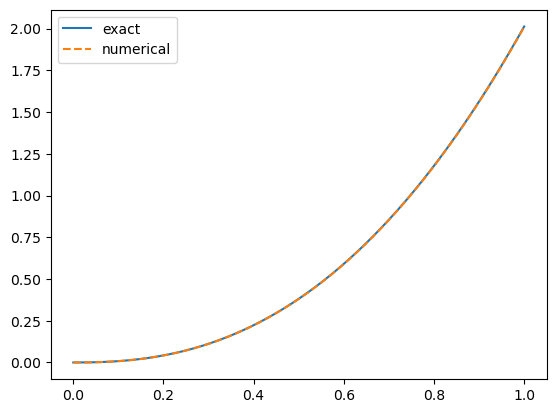

In [27]:
# Test power of a function
alpha = 0.6
b = 3
t0 = 0
tf = 1
num_step = 1000
y0 = 0

f = lambda t, y, alpha=alpha, b=b: gamma(b + 1) / gamma(b - alpha + 1) * (t ** (b - alpha) - t0 ** (b - alpha))

# Integrate
ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)
ts = torch.from_numpy(ts).float().unsqueeze(1)
ys = torch.from_numpy(ys).float().unsqueeze(1)

# Now derivative
fps = torch_caputo_l1_diff(ys, alpha, dt=0.001)
fig, ax = plt.subplots()
ax.plot(ts, np.vectorize(f)(ts, ys), label='exact')
ax.plot(ts, fps, label='numerical', ls='--')
ax.legend()